In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import holoviews as hv
from holoviews import opts
import hvplot.xarray
import hvplot.networkx as hvnx
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm

import networkx as nx
import geonetworkx as gnx


import warnings

warnings.filterwarnings('ignore')
hv.extension('bokeh')

## function to get stats

In [2]:
import scipy.stats as stats

def get_stats(obs, mod):
    corr, corr_p = stats.pearsonr(obs, mod)
    nse = 1 - (np.sum((obs - mod)**2)/np.sum((obs - np.mean(obs))**2))
    nse1 = 1 - (np.sum(np.abs(obs - mod))/np.sum(np.abs(obs - np.mean(obs))))
    rmse = np.sqrt(np.sum((obs-mod)**2)/len(mod))
    norm_rmse = rmse/(np.max(obs) - np.min(obs))
    mae = np.sum(np.abs(mod-obs))/len(mod)
    norm_mae = mae/(np.max(obs) - min(obs))
    kge = 1 - np.sqrt((corr-1)**2 +  (np.std(mod)/np.std(obs) - 1)**2 + (np.mean(mod)/np.mean(obs) - 1)**2) 

    # print({'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge})

    return {'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge}

## load modules

In [3]:
from reservoirnetwork.network import ReservoirNetwork

%load_ext autoreload
%autoreload 2

In [4]:
# quick and simple implementation without landlab
river_network_pts_fn = Path('/tiger1/pdas47/ResORR-revision/data-cumberland/cumberland_rivreg_usace/rivreg_pts.geojson')
river_network_fn = Path('/tiger1/pdas47/ResORR-revision/data-cumberland/cumberland_rivreg_usace/rivreg.geojson')

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
G

{0: Text(0.590846922684882, 1.0, '0'),
 1: Text(0.19216242752321122, -0.8548640721948632, '1'),
 2: Text(-0.02959282188973274, -0.4907437955353067, '2'),
 3: Text(-0.5473883754916717, -0.13882941916342287, '3'),
 4: Text(0.1282057254984059, 0.3934378466885708, '4'),
 5: Text(0.1586608564095832, 0.851433562502442, '5'),
 6: Text(-0.37322312013318004, -0.6565419676971556, '6'),
 7: Text(-0.11967161460149783, -0.1038921546002636, '7')}

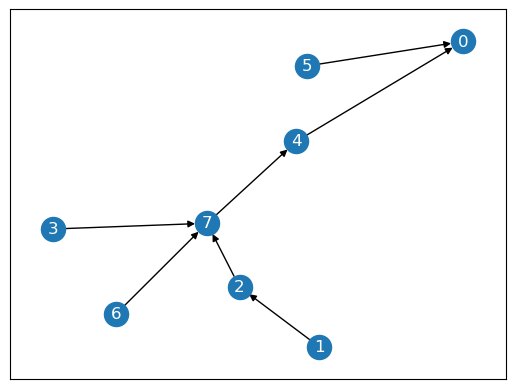

In [5]:
# plot reservoir network

pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [6]:
# aggregate
def aggregate(ds, frequency='weekly'):
    if frequency == 'daily':
        resampled = ds
        resampled['dt'] = ds['time'].resample(time='1D').count()
    elif frequency == 'weekly':
        resampled = ds.resample(time='1W').mean()
        resampled['dt'] = ds['time'].resample(time='1W').count()
    elif frequency == 'monthly':
        resampled = ds.resample(time='1M').mean()
        resampled['dt'] = ds['time'].resample(time='1M').count()
    elif frequency == 'annual':
        resampled = ds.resample(time='1Y').mean()
        resampled['dt'] = ds['time'].resample(time='1Y').count()
    else:
        raise ValueError(f'frequency {frequency} not supported')
    
    return resampled

def calculate_volumes(
        ds, 
        fluxes=['unregulated_inflow', 'obs_inflow', 'obs_outflow', 'obs_storage_change']
    ):
    """Calculate volume values using flow rates and ∆t

    Args:
        ds (xr.Dataset): Dataset containing flow rates in m3/day
    """
    for flux in fluxes:
        ds[flux] = ds[flux] * ds['dt']
        ds[flux].attrs['units'] = 'm3'
        ds[flux].attrs['long_name'] = f'Volume of {flux}'
        ds[flux].attrs['description'] = f'Volume of {flux} in m3'

    return ds

## create forcings

In [7]:
run_type = 'E4'
ds = xr.open_dataset(f'/tiger1/pdas47/ResORR-revision/data-cumberland/regulation-data/insitu.2015-2019.regulated.{run_type}.nc')

start_time = pd.to_datetime('2018-01-01')
end_time = pd.to_datetime('2019-09-30')

subset = ds.sel(time=slice(start_time, end_time))
aggregated_subset = calculate_volumes(aggregate(subset, 'daily'))

if start_time < aggregated_subset.time.min():
    start_time = aggregated_subset.time.min().values
if end_time > aggregated_subset.time.max():
    end_time = aggregated_subset.time.max().values

forcings = xr.Dataset(
    data_vars={
        'theoretical_natural_runoff': aggregated_subset['unregulated_inflow'],
        'storage_change': aggregated_subset['obs_storage_change'],
        'obs_inflow': aggregated_subset['obs_inflow'],
        'obs_outflow': aggregated_subset['obs_outflow'],
        'dt': aggregated_subset['dt']
    }
).sel(time=slice(start_time, end_time))
forcings

<xarray.Dataset> Size: 174kB
Dimensions:                     (time: 638, node: 8)
Coordinates:
  * time                        (time) datetime64[ns] 5kB 2018-01-01 ... 2019...
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
Data variables:
    theoretical_natural_runoff  (time, node) float64 41kB 1.419e+08 ... 1.111...
    storage_change              (time, node) float64 41kB -3.056e+07 ... -4.1...
    obs_inflow                  (time, node) float64 41kB 1.313e+08 ... 7.098...
    obs_outflow                 (time, node) float64 41kB 1.589e+08 ... 1.125...
    dt                          (time) int64 5kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1

## add noise to forcings data - storage change

- We will take the example of the Cordell Hull dam. It has 3 upstream dams, Laurel Dam, Wolf creek dam and Dale Hollow dam.
- Laurel Dam and Dale Hollow Dam are upstream most dams. Wolf Creek is right upstream of Cordell Hull.
- We will add random noise to input data to the `storage_change` of (1) Wolf Creek [`node: 2`] and (2) Dale Hollow Dam [`node: 3`].

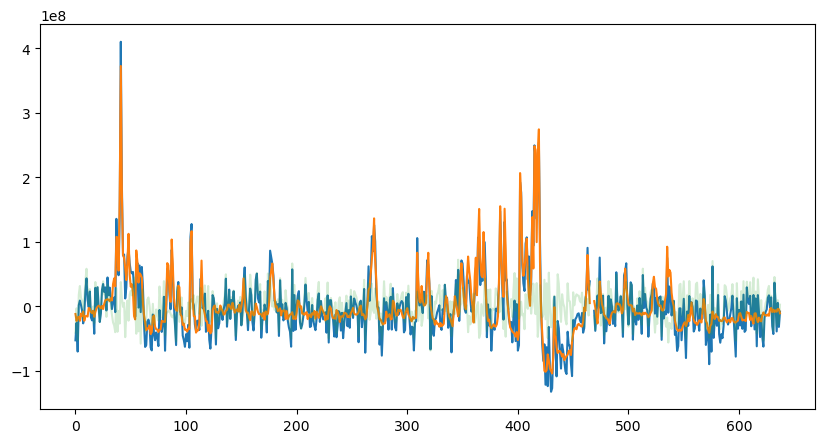

In [12]:
data = forcings['storage_change'].sel(node=2)

def add_gaussian_noise(data, std_dev):
    # abs_data = np.abs(data)
    # scaled_data = np.clip(1.5 - (data.max() - data)/(data.max()-data.min()), a_min=0.1, a_max=None)
    noise = np.random.normal(0, std_dev, len(data))
    return data + noise

noisy_data = add_gaussian_noise(data, data.std()*0.5)
noise = noisy_data - data

plt.figure(figsize=(10, 5))
# data.plot()
# plt.plot(noise, label='Noise')
plt.plot(noisy_data, label='Noisy Data')
plt.plot(data, label='Data')
plt.plot(noise, label='Normalized Data', alpha=0.2)

### another way of adding noise

* take the difference of observed and TNR
* add the scaled difference to the observed (say 0.5 times, 0.7 times, etc).
* at scaling of 0, data would be equal to observed, at scaling of 1, data would be equal to TNR.

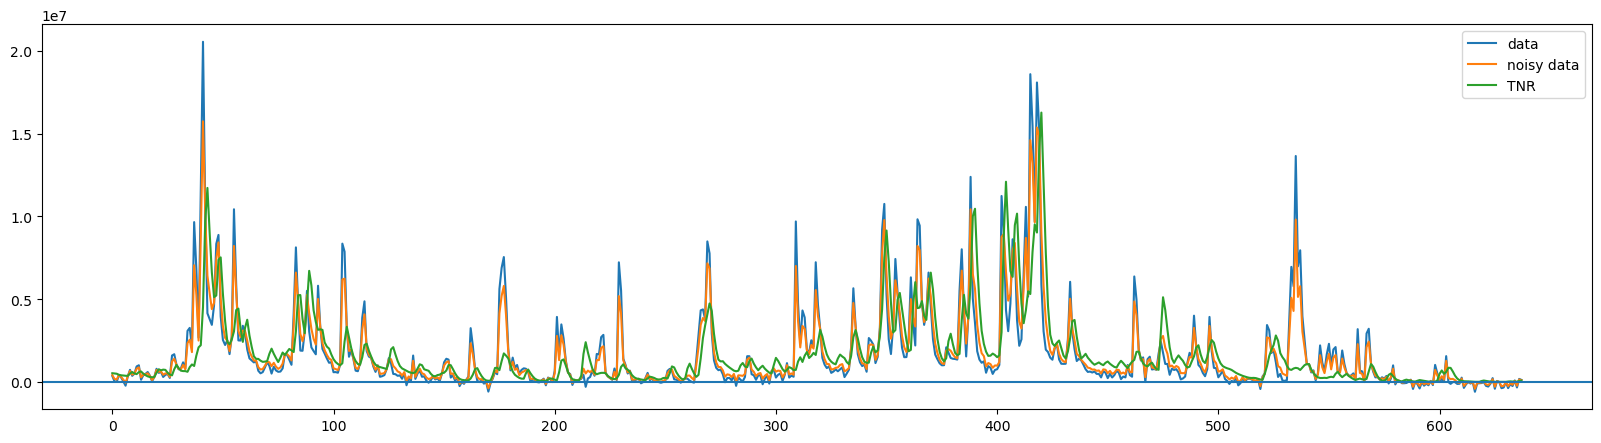

In [9]:
import matplotlib.pyplot as plt
# plt.plot(flow_scaling_factor(forcings['theoretical_natural_runoff'].sel(node=1).values))
plt.figure(figsize=(20, 5))

data = forcings['obs_inflow'].sel(node=1).fillna(0)
tnr = forcings['theoretical_natural_runoff'].sel(node=1).values

tnr_minus_data = tnr - data

noisy_data = data + tnr_minus_data * 0.3
# noisy_data, noise = add_scaled_gaussian_noise(data, noise_std_base, flow_scaling_factor)

# plt.plot(noise, label='noise')
plt.plot(data, label='data')
plt.plot(noisy_data, label='noisy data')
# plt.axhline(data.mean())
# plt.axhline(data.mean() + data.std(), linestyle='--')
plt.plot(tnr, label='TNR')
plt.legend()
plt.axhline(0)

In [10]:
forcings['obs_inflow'].sel(node=1).max()

<xarray.DataArray 'obs_inflow' ()> Size: 8B
array(20553609.6)
Coordinates:
    node     int64 8B 1

In [11]:
## USING GAUSSIAN NOISE

orig_obs_inflow_1 = forcings['obs_inflow'].sel(node=1).fillna(0)
orig_obs_inflow_3 = forcings['obs_inflow'].sel(node=3).fillna(0)

noise_std_dev_1 = 5e6         # m3
noise_std_dev_3 = 7e6

noisy_obs_inflows_1 = []
noisy_obs_inflows_3 = []
rmses_1 = []
rmses_3 = []

for noise_std_dev_1 in np.linspace(0, 150e6, 10):
    noisy_obs_inflow_1 = add_scaled_gaussian_noise(orig_obs_inflow_1.fillna(0), noise_std_dev_1, flow_scaling_factor)
    noisy_inflow_stats_1 = get_stats(orig_obs_inflow_1.fillna(0).values, noisy_obs_inflow_1.fillna(0).values)
    noisy_inflow_nrmse_1 = noisy_inflow_stats_1['norm_rmse']
    rmses_1.append(noisy_inflow_nrmse_1)
    noisy_obs_inflows_1.append(noisy_obs_inflow_1)
    print(f'1: {noise_std_dev_1:.2f}, {noisy_inflow_nrmse_1:.2f}')


for noise_std_dev_3 in np.linspace(0, 600e6, 10):
    noisy_obs_inflow_3 = add_scaled_gaussian_noise(orig_obs_inflow_3.fillna(0), noise_std_dev_3, flow_scaling_factor)
    noisy_inflow_stats_3 = get_stats(orig_obs_inflow_3.fillna(0).values, noisy_obs_inflow_3.fillna(0).values)
    noisy_inflow_nrmse_3 = noisy_inflow_stats_3['norm_rmse']
    rmses_3.append(noisy_inflow_nrmse_3)
    noisy_obs_inflows_3.append(noisy_obs_inflow_1)
    print(f'3: {noise_std_dev_3:.2f}, {noisy_inflow_nrmse_3:.2f}')


# ### USING ORIG - TNR

# orig_obs_inflow_1 = forcings['obs_inflow'].sel(node=1).fillna(0)
# orig_obs_inflow_3 = forcings['obs_inflow'].sel(node=3).fillna(0)

# noisy_obs_inflows_1 = []
# noisy_obs_inflows_3 = []
# rmses_1 = []
# rmses_3 = []

# diff_1 = forcings['theoretical_natural_runoff'].sel(node=1).values - orig_obs_inflow_1.fillna(0).values
# diff_3 = forcings['theoretical_natural_runoff'].sel(node=3).values - orig_obs_inflow_3.fillna(0).values

# for scaling_factor in np.linspace(0, 1, 10):
#     noisy_obs_inflow_1 = orig_obs_inflow_1 + diff_1 * scaling_factor
#     noisy_inflow_stats_1 = get_stats(orig_obs_inflow_1.fillna(0).values, noisy_obs_inflow_1.fillna(0).values)
#     noisy_inflow_nrmse_1 = noisy_inflow_stats_1['norm_rmse']
#     rmses_1.append(noisy_inflow_nrmse_1)
#     noisy_obs_inflows_1.append(noisy_obs_inflow_1)
#     print(f'1: {scaling_factor:.2f}, {noisy_inflow_nrmse_1:.2f}')
#     noisy_obs_inflow_3 = orig_obs_inflow_3 + diff_3 * scaling_factor
#     noisy_inflow_stats_3 = get_stats(orig_obs_inflow_3.fillna(0).values, noisy_obs_inflow_3.fillna(0).values)
#     noisy_inflow_nrmse_3 = noisy_inflow_stats_3['norm_rmse']
#     rmses_3.append(noisy_inflow_nrmse_3)
#     noisy_obs_inflows_3.append(noisy_obs_inflow_3)
#     print(f'3: {scaling_factor:.2f}, {noisy_inflow_nrmse_3:.2f}')



NameError: name 'add_scaled_gaussian_noise' is not defined

In [ ]:
noisy_obs_inflows_1[-1].hvplot() * orig_obs_inflow_1.hvplot() * forcings['theoretical_natural_runoff'].sel(node=1).hvplot()

:Overlay
   .Curve.I   :Curve   [time]   (obs_inflow)
   .Curve.II  :Curve   [time]   (obs_inflow)
   .Curve.III :Curve   [time]   (theoretical_natural_runoff)

## run for noisy forcings [-1]

In [ ]:
noisy_forcings = forcings.copy(deep=True)
noisy_forcings['storage_change'].loc[dict(node=[2])] = noisy_data

noisy_forcings

<xarray.Dataset> Size: 472kB
Dimensions:                     (time: 1734, node: 8)
Coordinates:
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
Data variables:
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
(noisy_forcings.sel(node=2) - forcings.sel(node=2))['storage_change'].rename('noisy - obs (m3)').hvplot(x='time')

:Curve   [time]   (noisy - obs (m3))

### run resorr

In [ ]:
reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(noisy_forcings.time.values):
    dt = aggregated_subset['dt'].sel(time=timestep).values.item()
    # reservoir_network.update(noisy_forcings, dt, 'wb_obs_inflow_upstream')
    reservoir_network.update(forcings, dt, 'wb_obs_inflow_upstream')

reservoir_network.data

  0%|          | 0/1734 [00:00<?, ?it/s]

<xarray.Dataset> Size: 1MB
Dimensions:                     (node: 8, time: 1734)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
Data variables:
    inflow                      (node, time) float64 111kB 1.149e+08 ... 1.46...
    outflow                     (node, time) float64 111kB 1.149e+08 ... 1.87...
    regulated_runoff            (node, time) float64 111kB 9.341e+07 ... 1.46...
    natural_runoff              (node, time) float64 111kB 2.144e+07 ... -2.3...
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage                     (node, time) float64 111kB nan nan ... nan nan
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    regulation                  (node, time) float64 111kB -2.299e+07 ... -1....
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

`reservoir_network.data` contains the model results. Plotting and analysis below.

In [ ]:
ds = reservoir_network.data

In [ ]:
NODE = 4
ds.sel(node=NODE).hvplot('time', 'obs_inflow', label='observed inflow') \
* ds.sel(node=NODE).hvplot('time', 'inflow', label='modeled inflow') \
* ds.sel(node=NODE).hvplot('time', 'outflow', label='outflow') \
* ds.sel(node=NODE).hvplot('time', 'theoretical_natural_runoff', label='tnr')

:Overlay
   .Curve.Observed_inflow :Curve   [time]   (obs_inflow)
   .Curve.Modeled_inflow  :Curve   [time]   (inflow)
   .Curve.Outflow         :Curve   [time]   (outflow)
   .Curve.Tnr             :Curve   [time]   (theoretical_natural_runoff)

In [ ]:
# reservoir_network.data.to_netcdf(f'/water2/pdas47/2023_01_24-river-regulation/regulation-experiments/regulation-results/insitu.2015-2019.regulated.{run_type}.nc')

In [ ]:
node = 4

ds = reservoir_network.data
ds['obs_inflow'] = subset['obs_inflow']

ds['inflow'].sel(node=node).hvplot(label='inflow') * ds['obs_inflow'].sel(node=node).hvplot(label='observed') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR')

:Overlay
   .Curve.Inflow   :Curve   [time]   (inflow)
   .Curve.Observed :Curve   [time]   (obs_inflow)
   .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)

In [ ]:
from bokeh.models.formatters import NumeralTickFormatter

# plot comparing downstream and upstream nodes
# node = 0
current_node_plot = ds['inflow'].sel(node=node).hvplot(label='inflow').opts(color='#069af3') * ds['obs_inflow'].sel(node=node).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR').opts(color='green', line_dash='3 3')
current_node_plot = current_node_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'))

upstreams = list(reservoir_network.predecessors(node))

plots = [current_node_plot]
for upstream in upstreams:
    upstream_plot = ds['inflow'].sel(node=upstream).hvplot(label='inflow').opts(color='#a2cffe') * ds['obs_inflow'].sel(node=upstream).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=upstream).hvplot(label='TNR').opts(color='green', line_dash='dashed')
    upstream_plot *= ds['storage_change'].sel(node=upstream).hvplot(label='storage change').opts(color='gray')
    upstream_plot *= ds['outflow'].sel(node=upstream).hvplot(label='outflow').opts(color='red')
    upstream_plot = upstream_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'), ylabel='inflow [m3]')
    plots.append(upstream_plot)

import panel as pn

hv.Layout(plots).cols(1)

:Layout
   .Overlay.I  :Overlay
      .Curve.Inflow   :Curve   [time]   (inflow)
      .Curve.Observed :Curve   [time]   (obs_inflow)
      .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)
   .Overlay.II :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)

In [ ]:
node = 7

rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')

print('river regulation model results')
get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)

river regulation model results


{'pearson-r': 0.8244878593617265,
 'pearson-r p-val': 0.0,
 'nse': -0.3615519157255369,
 'nse1': 0.045385670788446686,
 'rmse': 32280278.53406104,
 'norm_rmse': 0.16524624987448477,
 'mae': 20646229.390010368,
 'norm_mae': 0.10569028941765987,
 'kge': 0.184588497547029}

In [ ]:
rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')

print('TNR vs. Obs results')
get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)

TNR vs. Obs results


{'pearson-r': 0.7472319712425397,
 'pearson-r p-val': 1.657697991059713e-309,
 'nse': -0.8929769249620678,
 'nse1': -0.1018741314369962,
 'rmse': 38062107.42495451,
 'norm_rmse': 0.19484405959065454,
 'mae': 23831138.27272658,
 'norm_mae': 0.1219941837135366,
 'kge': 0.030967545147717046}

### Save stats

- Focus on one dam, Cordell Hull dam.
- Although save stats for all dams.

In [ ]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:                     (node: 8, time: 1734)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
Data variables:
    inflow                      (node, time) float64 111kB 1.114e+08 ... 1.42...
    outflow                     (node, time) float64 111kB 1.114e+08 ... 1.84...
    regulated_runoff            (node, time) float64 111kB 8.996e+07 ... 1.43...
    natural_runoff              (node, time) float64 111kB 2.144e+07 ... -2.3...
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage                     (node, time) float64 111kB nan nan ... nan nan
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    regulation                  (node, time) float64 111kB -1.954e+07 ... -1....
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
nodes_with_upstream = [2, 4, 7, 0]
names = ['Wolf Creek Dam', 'Old Hickory Dam', 'Cordell Hull Dam', 'Barkley Dam']


dfs = []
for node, name in zip(nodes_with_upstream, names):
    print(name)
    rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')
    # print('river regulation model results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)
    model_df = pd.DataFrame(s, index=[node])
    model_df['name'] = name
    model_df['model_or_tnr'] = 'model'

    rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')
    # print('TNR vs. Obs results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)
    tnr_df = pd.DataFrame(s, index=[node])
    tnr_df['name'] = name
    tnr_df['model_or_tnr'] = 'tnr'

    dfs.append(pd.concat([model_df, tnr_df]))

df = pd.concat(dfs)
df

Wolf Creek Dam
Old Hickory Dam
Cordell Hull Dam
Barkley Dam


,pearson-r,pearson-r p-val,nse,nse1,rmse,norm_rmse,mae,norm_mae,kge,name,model_or_tnr
2,0.655255,3.960466e-213,0.426134,0.364890,3.229589e+07,0.080233,1.681273e+07,0.041768,0.548997,Wolf Creek Dam,model
2,0.631365,2.160983e-193,0.393654,0.378159,3.319727e+07,0.082473,1.646146e+07,0.040896,0.494023,Wolf Creek Dam,tnr
4,0.792941,0.000000e+00,0.417166,0.356620,3.370259e+07,0.121989,2.186026e+07,0.079125,0.670142,Old Hickory Dam,model
4,0.796772,0.000000e+00,0.379965,0.310337,3.476153e+07,0.125821,2.343283e+07,0.084817,0.636085,Old Hickory Dam,tnr
7,0.804505,0.000000e+00,-0.689746,-0.099534,3.596092e+07,0.184088,2.378052e+07,0.121735,0.084901,Cordell Hull Dam,model
7,0.747232,1.657698e-309,-0.892977,-0.101874,3.806211e+07,0.194844,2.383114e+07,0.121994,0.030968,Cordell Hull Dam,tnr
0,0.784517,0.000000e+00,0.467504,0.326400,5.173161e+07,0.090536,3.463025e+07,0.060607,0.725712,Barkley Dam,model
0,0.838198,0.000000e+00,0.578872,0.356372,4.600496e+07,0.080514,3.308937e+07,0.057910,0.745146,Barkley Dam,tnr


## run for noisy forcings [0]

In [ ]:
noisy_forcings = forcings.copy(deep=True)
# noisy_forcings['obs_inflow'].loc[dict(node=[1, 3])] = xr.concat([noisy_obs_inflow_1, noisy_obs_inflow_3], dim='node')
noisy_forcings['obs_inflow'].loc[dict(node=[1])] = noisy_obs_inflows_1[0]
noisy_forcings['obs_inflow'].loc[dict(node=[3])] = noisy_obs_inflows_3[0]
noisy_forcings

<xarray.Dataset> Size: 472kB
Dimensions:                     (time: 1734, node: 8)
Coordinates:
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
Data variables:
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
noisy_forcings.sel(node=1)

<xarray.Dataset> Size: 83kB
Dimensions:                     (time: 1734)
Coordinates:
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
    node                        int64 8B 1
Data variables:
    theoretical_natural_runoff  (time) float64 14kB 1.137e+06 ... 8.966e+04
    storage_change              (time) float64 14kB -8.02e+05 ... 1.47e+05
    obs_inflow                  (time) float64 14kB 1.122e+06 ... 1.368e+05
    obs_outflow                 (time) float64 14kB 1.713e+06 0.0 ... 0.0
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
forcings.sel(node=1)

<xarray.Dataset> Size: 83kB
Dimensions:                     (time: 1734)
Coordinates:
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
    node                        int64 8B 1
Data variables:
    theoretical_natural_runoff  (time) float64 14kB 1.137e+06 ... 8.966e+04
    storage_change              (time) float64 14kB -8.02e+05 ... 1.47e+05
    obs_inflow                  (time) float64 14kB 1.201e+06 ... 1.297e+05
    obs_outflow                 (time) float64 14kB 1.713e+06 0.0 ... 0.0
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
(noisy_forcings.sel(node=1) - forcings.sel(node=1))['obs_inflow'].rename('noisy - obs (m3)').hvplot(x='time')

:Curve   [time]   (noisy - obs (m3))

In [ ]:
noisy_forcings.sel(node=1)['obs_inflow'].hvplot().opts(title='Laurel Dam')# * noisy_obs_inflow_1.hvplot()

:Curve   [time]   (obs_inflow)

### run resorr

In [ ]:
reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(noisy_forcings.time.values):
    dt = aggregated_subset['dt'].sel(time=timestep).values.item()
    reservoir_network.update(noisy_forcings, dt, 'wb_obs_inflow_upstream')

reservoir_network.data

  0%|          | 0/1734 [00:00<?, ?it/s]

<xarray.Dataset> Size: 1MB
Dimensions:                     (node: 8, time: 1734)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
Data variables:
    inflow                      (node, time) float64 111kB 1.117e+08 ... 1.42...
    outflow                     (node, time) float64 111kB 1.117e+08 ... 1.84...
    regulated_runoff            (node, time) float64 111kB 9.026e+07 ... 1.43...
    natural_runoff              (node, time) float64 111kB 2.144e+07 ... -2.3...
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage                     (node, time) float64 111kB nan nan ... nan nan
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    regulation                  (node, time) float64 111kB -1.984e+07 ... -1....
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

`reservoir_network.data` contains the model results. Plotting and analysis below.

In [ ]:
ds = reservoir_network.data

In [ ]:
noisy_forcings.sel(node=1)['obs_inflow'].hvplot(label='noisy') * ds.sel(node=1)['obs_inflow'].hvplot()

:Overlay
   .Curve.Noisy :Curve   [time]   (obs_inflow)
   .Curve.I     :Curve   [time]   (obs_inflow)

In [ ]:
NODE = 2
ds.sel(node=NODE).hvplot('time', 'obs_inflow', label='observed inflow') \
* ds.sel(node=NODE).hvplot('time', 'inflow', label='modeled inflow') \
* ds.sel(node=NODE).hvplot('time', 'outflow', label='outflow') \
* ds.sel(node=NODE).hvplot('time', 'theoretical_natural_runoff', label='tnr')

:Overlay
   .Curve.Observed_inflow :Curve   [time]   (obs_inflow)
   .Curve.Modeled_inflow  :Curve   [time]   (inflow)
   .Curve.Outflow         :Curve   [time]   (outflow)
   .Curve.Tnr             :Curve   [time]   (theoretical_natural_runoff)

In [ ]:
# reservoir_network.data.to_netcdf(f'/water2/pdas47/2023_01_24-river-regulation/regulation-experiments/regulation-results/insitu.2015-2019.regulated.{run_type}.nc')

In [ ]:
node = 0

ds = reservoir_network.data
ds['obs_inflow'] = subset['obs_inflow']

ds['inflow'].sel(node=node).hvplot(label='inflow') * ds['obs_inflow'].sel(node=node).hvplot(label='observed') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR')

:Overlay
   .Curve.Inflow   :Curve   [time]   (inflow)
   .Curve.Observed :Curve   [time]   (obs_inflow)
   .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)

In [ ]:
from bokeh.models.formatters import NumeralTickFormatter

# plot comparing downstream and upstream nodes
# node = 0
current_node_plot = ds['inflow'].sel(node=node).hvplot(label='inflow').opts(color='#069af3') * ds['obs_inflow'].sel(node=node).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR').opts(color='green', line_dash='3 3')
current_node_plot = current_node_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'))

upstreams = list(reservoir_network.predecessors(node))

plots = [current_node_plot]
for upstream in upstreams:
    upstream_plot = ds['inflow'].sel(node=upstream).hvplot(label='inflow').opts(color='#a2cffe') * ds['obs_inflow'].sel(node=upstream).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=upstream).hvplot(label='TNR').opts(color='green', line_dash='dashed')
    upstream_plot *= ds['storage_change'].sel(node=upstream).hvplot(label='storage change').opts(color='gray')
    upstream_plot *= ds['outflow'].sel(node=upstream).hvplot(label='outflow').opts(color='red')
    upstream_plot = upstream_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'), ylabel='inflow [m3]')
    plots.append(upstream_plot)

import panel as pn

hv.Layout(plots).cols(1)

:Layout
   .Overlay.I   :Overlay
      .Curve.Inflow   :Curve   [time]   (inflow)
      .Curve.Observed :Curve   [time]   (obs_inflow)
      .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)
   .Overlay.II  :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)
   .Overlay.III :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)

In [ ]:
node = 2

rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')

print('river regulation model results')
get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)

river regulation model results


{'pearson-r': 0.6372398778132224,
 'pearson-r p-val': 4.395207566090261e-198,
 'nse': 0.40246353862539863,
 'nse1': 0.38375329163207705,
 'rmse': 32955219.290662564,
 'norm_rmse': 0.08187130927106118,
 'mae': 16313365.162265401,
 'norm_mae': 0.04052761878692793,
 'kge': 0.4927684459101591}

In [ ]:
rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')

print('TNR vs. Obs results')
get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)

TNR vs. Obs results


{'pearson-r': 0.631364696651363,
 'pearson-r p-val': 2.160983410173374e-193,
 'nse': 0.39365381627417095,
 'nse1': 0.3781587898672444,
 'rmse': 33197266.48566465,
 'norm_rmse': 0.08247263195034384,
 'mae': 16461463.560117071,
 'norm_mae': 0.040895542593658546,
 'kge': 0.49402349938157075}

### Save stats

- Focus on one dam, Cordell Hull dam.
- Although save stats for all dams.

In [ ]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:                     (node: 8, time: 1734)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
Data variables:
    inflow                      (node, time) float64 111kB 1.117e+08 ... 1.42...
    outflow                     (node, time) float64 111kB 1.117e+08 ... 1.84...
    regulated_runoff            (node, time) float64 111kB 9.026e+07 ... 1.43...
    natural_runoff              (node, time) float64 111kB 2.144e+07 ... -2.3...
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage                     (node, time) float64 111kB nan nan ... nan nan
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    regulation                  (node, time) float64 111kB -1.984e+07 ... -1....
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
nodes_with_upstream = [2, 4, 7, 0]
names = ['Wolf Creek Dam', 'Old Hickory Dam', 'Cordell Hull Dam', 'Barkley Dam']


dfs = []
for node, name in zip(nodes_with_upstream, names):
    print(name)
    rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')
    # print('river regulation model results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)
    model_df = pd.DataFrame(s, index=[node])
    model_df['name'] = name
    model_df['model_or_tnr'] = 'model'

    rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')
    # print('TNR vs. Obs results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)
    tnr_df = pd.DataFrame(s, index=[node])
    tnr_df['name'] = name
    tnr_df['model_or_tnr'] = 'tnr'

    dfs.append(pd.concat([model_df, tnr_df]))

df = pd.concat(dfs)
df

Wolf Creek Dam
Old Hickory Dam
Cordell Hull Dam
Barkley Dam


,pearson-r,pearson-r p-val,nse,nse1,rmse,norm_rmse,mae,norm_mae,kge,name,model_or_tnr
2,0.637240,4.395208e-198,0.402464,0.383753,3.295522e+07,0.081871,1.631337e+07,0.040528,0.492768,Wolf Creek Dam,model
2,0.631365,2.160983e-193,0.393654,0.378159,3.319727e+07,0.082473,1.646146e+07,0.040896,0.494023,Wolf Creek Dam,tnr
4,0.800395,0.000000e+00,0.480439,0.401897,3.182065e+07,0.115177,2.032186e+07,0.073556,0.715255,Old Hickory Dam,model
4,0.796772,0.000000e+00,0.379965,0.310337,3.476153e+07,0.125821,2.343283e+07,0.084817,0.636085,Old Hickory Dam,tnr
7,0.817204,0.000000e+00,-0.413636,0.002759,3.289190e+07,0.168377,2.156815e+07,0.110410,0.177038,Cordell Hull Dam,model
7,0.747232,1.657698e-309,-0.892977,-0.101874,3.806211e+07,0.194844,2.383114e+07,0.121994,0.030968,Cordell Hull Dam,tnr
0,0.786846,0.000000e+00,0.489281,0.341201,5.066272e+07,0.088665,3.386931e+07,0.059275,0.740954,Barkley Dam,model
0,0.838198,0.000000e+00,0.578872,0.356372,4.600496e+07,0.080514,3.308937e+07,0.057910,0.745146,Barkley Dam,tnr


## all in one, in a loop

In [13]:
from dask.distributed import Client, LocalCluster

client = Client(n_workers=10, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 187.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33979,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 187.55 GiB
Comm: tcp://127.0.0.1:42565,Total threads: 1
Dashboard: http://127.0.0.1:46665/status,Memory: 18.76 GiB
Nanny: tcp://127.0.0.1:39017,


In [14]:
import dask
np.random.seed(0)

# Load the data
run_type = 'E4'
ds = xr.open_dataset(f'/tiger1/pdas47/ResORR-revision/data-cumberland/regulation-data/insitu.2015-2019.regulated.{run_type}.nc')

start_time = pd.to_datetime('2018-01-01')
end_time = pd.to_datetime('2019-09-30')

subset = ds.sel(time=slice(start_time, end_time))
aggregated_subset = calculate_volumes(aggregate(subset, 'daily'))

if start_time < aggregated_subset.time.min():
    start_time = aggregated_subset.time.min().values
if end_time > aggregated_subset.time.max():
    end_time = aggregated_subset.time.max().values

forcings = xr.Dataset(
    data_vars={
        'theoretical_natural_runoff': aggregated_subset['unregulated_inflow'],
        'storage_change': aggregated_subset['obs_storage_change'],
        'obs_inflow': aggregated_subset['obs_inflow'],
        'obs_outflow': aggregated_subset['obs_outflow'],
        'dt': aggregated_subset['dt']
    }
).sel(time=slice(start_time, end_time))

def add_gaussian_noise(data, std_dev):
    # abs_data = np.abs(data)
    # scaled_data = np.clip(1.5 - (data.max() - data)/(data.max()-data.min()), a_min=0.1, a_max=None)
    noise = np.random.normal(0, std_dev, len(data))
    return data + noise

# noisy_data = add_gaussian_noise(data, data.std()*0.5)
# noise = noisy_data - data

## USING GAUSSIAN NOISE
data_2 = forcings['storage_change'].sel(node=2).fillna(0)
data_3 = forcings['storage_change'].sel(node=3).fillna(0)
data_6 = forcings['storage_change'].sel(node=6).fillna(0)
noise_std_devs_2 = []
noise_std_devs_3 = []
noise_std_devs_6 = []
noisy_storage_changes_2 = []
noisy_storage_changes_3 = []
noisy_storage_changes_6 = []
rmses_2 = []
rmses_3 = []
rmses_6 = []

for noise_std_dev in np.linspace(0, 1.5, 10):
# for noise_std_dev in np.linspace(0, 1, 10): # added rmse 0 -> 0.08
    noisy_storage_change = add_gaussian_noise(data_2, noise_std_dev*data_2.std())
    noisy_storage_change_stats = get_stats(data_2.values, noisy_storage_change.values)
    noisy_storage_change_nrmse = noisy_storage_change_stats['norm_rmse']
    rmses_2.append(noisy_storage_change_nrmse)
    noisy_storage_changes_2.append(noisy_storage_change)
    noise_std_devs_2.append(noise_std_dev)
    print(f'2: {noise_std_dev:.2f}, {noisy_storage_change_nrmse:.2f}')

for noise_std_dev in np.linspace(0, 1.5, 10):
# for noise_std_dev in np.linspace(0, 1, 10): # added rmse 0 -> 0.08
    noisy_storage_change = add_gaussian_noise(data_3, noise_std_dev*data_3.std())
    noisy_storage_change_stats = get_stats(data_3.values, noisy_storage_change.values)
    noisy_storage_change_nrmse = noisy_storage_change_stats['norm_rmse']
    rmses_3.append(noisy_storage_change_nrmse)
    noisy_storage_changes_3.append(noisy_storage_change)
    noise_std_devs_3.append(noise_std_dev)
    print(f'3: {noise_std_dev:.2f}, {noisy_storage_change_nrmse:.2f}')

for noise_std_dev in np.linspace(0, 2, 10):
# for noise_std_dev in np.linspace(0, 1, 10): # added rmse 0 -> 0.08
    noisy_storage_change = add_gaussian_noise(data_6, noise_std_dev*data_6.std())
    noisy_storage_change_stats = get_stats(data_6.values, noisy_storage_change.values)
    noisy_storage_change_nrmse = noisy_storage_change_stats['norm_rmse']
    rmses_6.append(noisy_storage_change_nrmse)
    noisy_storage_changes_6.append(noisy_storage_change)
    noise_std_devs_6.append(noise_std_dev)
    print(f'6: {noise_std_dev:.2f}, {noisy_storage_change_nrmse:.2f}')

case_dfs = []

def run_for_case(i):
    noisy_forcings = forcings.copy(deep=True)
    noisy_forcings['storage_change'].loc[dict(node=[2])] = noisy_storage_changes_2[i]
    noisy_forcings['storage_change'].loc[dict(node=[3])] = noisy_storage_changes_3[i]
    noisy_forcings['storage_change'].loc[dict(node=[6])] = noisy_storage_changes_6[i]
    
    reservoir_network = ReservoirNetwork(G, start_time)

    for timestep in tqdm(noisy_forcings.time.values):
        dt = aggregated_subset['dt'].sel(time=timestep).values.item()
        reservoir_network.update(noisy_forcings, dt, 'wb_obs_inflow_upstream')

    ds = reservoir_network.data

    nodes_with_upstream = [2, 4, 7, 0]
    names = ['Wolf Creek Dam', 'Old Hickory Dam', 'Cordell Hull Dam', 'Barkley Dam']

    dfs = []
    for node, name in zip(nodes_with_upstream, names):
        rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')
        # print('river regulation model results')
        s = get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)
        model_df = pd.DataFrame(s, index=[node])
        model_df['name'] = name
        model_df['model_or_tnr'] = 'model'

        rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')
        # print('TNR vs. Obs results')
        s = get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)
        tnr_df = pd.DataFrame(s, index=[node])
        tnr_df['name'] = name
        tnr_df['model_or_tnr'] = 'tnr'

        dfs.append(pd.concat([model_df, tnr_df]))

    case_df = pd.concat(dfs)
    print(case_df)
    case_df['added_rmse_2'] = rmses_2[i]
    case_df['added_rmse_3'] = rmses_3[i]
    case_df['added_rmse_6'] = rmses_6[i]
    case_df['noise_std_dev_2'] = noise_std_devs_2[i]
    case_df['noise_std_dev_3'] = noise_std_devs_3[i]
    case_df['noise_std_dev_6'] = noise_std_devs_6[i]
    case_dfs.append(case_df)

    return case_df

futures = []
# loop through the noisy datas and run the reservoir model
for i in range(len(rmses_2)):
    future = client.submit(run_for_case, i)
    futures.append(future)

print(futures)

2: 0.00, 0.00
2: 0.17, 0.02
2: 0.33, 0.03
2: 0.50, 0.05
2: 0.67, 0.06
2: 0.83, 0.08
2: 1.00, 0.10
2: 1.17, 0.11
2: 1.33, 0.13
2: 1.50, 0.14
3: 0.00, 0.00
3: 0.17, 0.02
3: 0.33, 0.03
3: 0.50, 0.05
3: 0.67, 0.07
3: 0.83, 0.08
3: 1.00, 0.10
3: 1.17, 0.11
3: 1.33, 0.14
3: 1.50, 0.15
6: 0.00, 0.00
6: 0.22, 0.02
6: 0.44, 0.03
6: 0.67, 0.05
6: 0.89, 0.07
6: 1.11, 0.08
6: 1.33, 0.10
6: 1.56, 0.12
6: 1.78, 0.13
6: 2.00, 0.15
[<Future: pending, key: run_for_case-d429e92e4b07ba455e9f8178fb3c0cf3>, <Future: pending, key: run_for_case-ef328b15de22c97b229a5b556e061820>, <Future: pending, key: run_for_case-50d3c62c519b7413a259fc2b6671e5bf>, <Future: pending, key: run_for_case-0e2c898d05880a8d618deb1b7b50b4b7>, <Future: pending, key: run_for_case-319b1c19dc3a404876f3268896ca958a>, <Future: pending, key: run_for_case-185227037fde8673643fae63ddcd175a>, <Future: pending, key: run_for_case-24c856b009a7b5e6d72ea5a1300039b5>, <Future: pending, key: run_for_case-aa18d93f0a801ba1223b0d53c01e5bbb>, <Future: pe

  0%|          | 0/638 [00:00<?, ?it/s]


In [15]:
results = client.gather(futures)
results

   pearson-r  pearson-r p-val  ...              name  model_or_tnr
2   0.679047     2.631539e-87  ...    Wolf Creek Dam         model
2   0.681003     5.453287e-88  ...    Wolf Creek Dam           tnr
4   0.633313     7.936012e-73  ...   Old Hickory Dam         model
4   0.790728    1.125232e-137  ...   Old Hickory Dam           tnr
7   0.618738     1.444564e-68  ...  Cordell Hull Dam         model
7   0.737924    1.556388e-110  ...  Cordell Hull Dam           tnr
0   0.740487    7.345799e-112  ...       Barkley Dam         model
0   0.863043    8.473164e-191  ...       Barkley Dam           tnr

[8 rows x 11 columns]
   pearson-r  pearson-r p-val  ...              name  model_or_tnr
2   0.679047     2.631539e-87  ...    Wolf Creek Dam         model
2   0.681003     5.453287e-88  ...    Wolf Creek Dam           tnr
4   0.603146     1.838134e-64  ...   Old Hickory Dam         model
4   0.790728    1.125232e-137  ...   Old Hickory Dam           tnr
7   0.582236     4.448972e-59  ...  Cor

[   pearson-r  pearson-r p-val       nse      nse1          rmse  norm_rmse  \
 2   0.679047     2.631539e-87  0.460062  0.385153  3.673953e+07   0.092320   
 2   0.681003     5.453287e-88  0.461750  0.384733  3.668205e+07   0.092175   
 4   0.798862    1.575496e-142  0.464015  0.397246  4.041942e+07   0.146979   
 4   0.790728    1.125232e-137  0.348333  0.325755  4.456836e+07   0.162066   
 7   0.818998    2.501866e-155 -0.594398 -0.083229  4.233829e+07   0.217161   
 7   0.737924    1.556388e-110 -1.249220 -0.197545  5.028644e+07   0.257929   
 0   0.811521    1.520483e-150  0.517846  0.373475  6.139017e+07   0.111702   
 0   0.863043    8.473164e-191  0.635882  0.427484  5.334906e+07   0.097071   
 
             mae  norm_mae       kge              name model_or_tnr  \
 2  2.030003e+07  0.051010  0.566768    Wolf Creek Dam        model   
 2  2.031391e+07  0.051045  0.577766    Wolf Creek Dam          tnr   
 4  2.608712e+07  0.094862  0.703743   Old Hickory Dam        model   
 4 

In [16]:
df = pd.concat(results)
df.index.name = 'node'
df.reset_index(inplace=True)
df.loc[(df['node'] == 7)&(df['model_or_tnr'] == 'model')]

,node,pearson-r,pearson-r p-val,nse,nse1,rmse,norm_rmse,mae,norm_mae,kge,name,model_or_tnr,added_rmse_2,added_rmse_3,added_rmse_6,noise_std_dev_2,noise_std_dev_3,noise_std_dev_6
4,7,0.818998,2.501866e-155,-0.594398,-0.083229,4.233829e+07,0.217161,2.808587e+07,0.144058,0.113971,Cordell Hull Dam,model,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,7,0.815067,1.160188e-152,-0.641836,-0.122238,4.296352e+07,0.220368,2.909729e+07,0.149246,0.099388,Cordell Hull Dam,model,0.015600,0.016382,0.016456,0.166667,0.166667,0.222222
20,7,0.795043,5.263722e-140,-0.801909,-0.213911,4.500921e+07,0.230861,3.147419e+07,0.161437,0.064278,Cordell Hull Dam,model,0.030943,0.031407,0.031253,0.333333,0.333333,0.444444
28,7,0.776132,2.760250e-129,-0.953379,-0.261939,4.686280e+07,0.240368,3.271947e+07,0.167825,0.032131,Cordell Hull Dam,model,0.046648,0.048254,0.049540,0.500000,0.500000,0.666667
36,7,0.740501,1.077521e-111,-1.315874,-0.404620,5.102610e+07,0.261723,3.641888e+07,0.186800,-0.040808,Cordell Hull Dam,model,0.061840,0.068447,0.065198,0.666667,0.666667,0.888889
44,7,0.696672,1.150802e-93,-1.574419,-0.521057,5.379905e+07,0.275946,3.943785e+07,0.202284,-0.082880,Cordell Hull Dam,model,0.081851,0.081344,0.081959,0.833333,0.833333,1.111111
52,7,0.685208,1.772977e-89,-2.151936,-0.654666,5.952832e+07,0.305332,4.290205e+07,0.220053,-0.239590,Cordell Hull Dam,model,0.095950,0.099638,0.099157,1.000000,1.000000,1.333333
60,7,0.618738,1.444564e-68,-2.382886,-0.721516,6.167066e+07,0.316321,4.463533e+07,0.228943,-0.242644,Cordell Hull Dam,model,0.112753,0.114610,0.116247,1.166667,1.166667,1.555556
68,7,0.620514,4.634134e-69,-3.119578,-0.834140,6.805520e+07,0.349068,4.755544e+07,0.243921,-0.424728,Cordell Hull Dam,model,0.125729,0.139008,0.129210,1.333333,1.333333,1.777778
76,7,0.582236,4.448972e-59,-3.494589,-0.931286,7.108532e+07,0.364610,5.007425e+07,0.256841,-0.470785,Cordell Hull Dam,model,0.144032,0.145909,0.148791,1.500000,1.500000,2.000000


In [17]:
# df.to_csv("/tiger1/pdas47/ResORR-revision/data-cumberland/regulation-results/gaussian_noise_dels_1.csv")

In [18]:
get_stats(
    forcings.sel(node=3)['theoretical_natural_runoff'].fillna(0).values, 
    forcings.sel(node=3)['obs_inflow'].fillna(0).values
)

{'pearson-r': 0.525108177901557,
 'pearson-r p-val': 1.6778006196830108e-46,
 'nse': -1.176165885432506,
 'nse1': -0.018338796576356176,
 'rmse': 8891893.641771145,
 'norm_rmse': 0.19336702416576293,
 'mae': 4757039.777065976,
 'norm_mae': 0.10344867612993507,
 'kge': 0.127717472973217}

In [19]:
# df = pd.read_csv("/tiger1/pdas47/ResORR-revision/data-cumberland/regulation-results/gaussian_noise_dels_1.csv")
# df

### add stats of resorr + satellite derived data

In [20]:
sat_resorr_results = xr.open_dataset('/tiger1/pdas47/ResORR-revision/data-cumberland/results/RAT.2018-2019.regulated.S1.nc')
sat_resorr_results

<xarray.Dataset> Size: 419kB
Dimensions:                     (node: 8, time: 638)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
  * time                        (time) datetime64[ns] 5kB 2018-01-01 ... 2019...
Data variables:
    inflow                      (node, time) float64 41kB ...
    outflow                     (node, time) float64 41kB ...
    regulated_runoff            (node, time) float64 41kB ...
    natural_runoff              (node, time) float64 41kB ...
    theoretical_natural_runoff  (time, node) float64 41kB ...
    storage                     (node, time) float64 41kB ...
    storage_change              (time, node) float64 41kB ...
    regulation                  (node, time) float64 41kB ...
    obs_inflow                  (time, node) float64 41kB ...
    obs_outflow                 (time, node) float64 41kB ...
    dt                          (time) int64 5kB ...

In [21]:
nodes_with_upstream = [2, 4, 7, 0]
names = ['Wolf Creek Dam', 'Old Hickory Dam', 'Cordell Hull Dam', 'Barkley Dam']

dfs = []
for node, name in zip(nodes_with_upstream, names):
    rr_res = sat_resorr_results[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')
    # print('river regulation model results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)
    model_df = pd.DataFrame(s, index=[node])
    model_df['name'] = name
    model_df['model_or_tnr'] = 'model'

    rr_res = sat_resorr_results[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')
    # print('TNR vs. Obs results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)
    tnr_df = pd.DataFrame(s, index=[node])
    tnr_df['name'] = name
    tnr_df['model_or_tnr'] = 'tnr'

    dfs.append(pd.concat([model_df, tnr_df]))

sat_df = pd.concat(dfs).reset_index().rename(columns={'index': 'node'})
sat_df

,node,pearson-r,pearson-r p-val,nse,nse1,rmse,norm_rmse,mae,norm_mae,kge,name,model_or_tnr
0,2,0.676369,2.226033e-86,0.456312,0.376331,3.686689e+07,0.092640,2.059131e+07,0.051742,0.565433,Wolf Creek Dam,model
1,2,0.681003,5.453287e-88,0.461750,0.384733,3.668205e+07,0.092175,2.031391e+07,0.051045,0.577766,Wolf Creek Dam,tnr
2,4,0.751822,3.871475e-117,0.383239,0.317881,4.335829e+07,0.157665,2.952203e+07,0.107352,0.693373,Old Hickory Dam,model
3,4,0.790728,1.125232e-137,0.348333,0.325755,4.456836e+07,0.162066,2.918123e+07,0.106113,0.620188,Old Hickory Dam,tnr
4,7,0.720885,3.383612e-103,-0.888800,-0.150658,4.608164e+07,0.236362,2.983416e+07,0.153025,0.099864,Cordell Hull Dam,model
5,7,0.737924,1.556388e-110,-1.249220,-0.197545,5.028644e+07,0.257929,3.104986e+07,0.159261,-0.073621,Cordell Hull Dam,tnr
6,0,0.841796,1.871779e-172,0.647027,0.462855,5.252625e+07,0.095573,3.519987e+07,0.064047,0.817956,Barkley Dam,model
7,0,0.863043,8.473164e-191,0.635882,0.427484,5.334906e+07,0.097071,3.751773e+07,0.068265,0.762981,Barkley Dam,tnr


In [22]:
# for node in 
added_rmse = get_stats(
    sat_resorr_results.sel(node=2)['storage_change'].fillna(0).values,
    forcings.sel(node=2, time=sat_resorr_results.time)['storage_change'].fillna(0).values
)['norm_rmse']

# sat stats
sat_df['added_rmse'] = added_rmse

In [23]:
import altair as alt
from altair import datum

In [24]:
alt.Chart(
    sat_df
).transform_filter(
    datum.node == 4
).mark_point().encode(
    x='added_rmse',
    y='nse',
    color='model_or_tnr'
)

alt.Chart(...)

In [26]:
NODE = 4
name = df[df.node == NODE].name.values[0]

df_clean = df.copy()
df_clean.loc[df_clean['model_or_tnr']=='model', 'model_or_tnr'] = 'ResORR - with reservoirs'
df_clean.loc[df_clean['model_or_tnr']=='tnr', 'model_or_tnr'] = 'TNR - without reservoirs'

pts = alt.Chart(
    df_clean
).transform_filter(
    datum.node == NODE
).mark_point(
    filled=True,
    size=100,
    opacity=1
).encode(
    x=alt.X('added_rmse_2:Q').title('Norm. RMSE added to Wolf Creek Dam'),
    y=alt.Y('nse:Q').title('KGE'), #.scale(alt.Scale(domain=[0.0, 0.15])),
    shape=alt.Shape('model_or_tnr').legend(alt.Legend(title="With or without reservoirs")),
    color=alt.Color('model_or_tnr').legend(alt.Legend(title="With or without reservoirs")).scale(alt.Scale(range=['darkblue', 'orange'])),
    tooltip=alt.Tooltip(['pearson-r', 'nse', 'norm_rmse', 'norm_mae', 'kge', 'rmse'], format='.2f')
)

line = alt.Chart(
    df
).transform_filter(
    datum.node == NODE
).mark_line(
    color='gray',
).encode(
    x='added_rmse_2:Q',
    y=alt.Y('nse:Q').title('KGE'),
    color=alt.Color('model_or_tnr').legend(None).scale(alt.Scale(range=['darkblue', 'orange'])),
    detail = alt.Detail('model_or_tnr'),
)

sat_pt = alt.Chart(
    sat_df
).transform_filter(
    (datum.node == NODE) #& (datum.model_or_tnr == 'model')
).mark_point(shape='cross', filled=True, angle=45, size=150).encode(
    x=alt.X('added_rmse:Q').axis(format='.2f', labelAngle=0),
    y=alt.Y('nse').title(None).axis(),
    color='model_or_tnr',
    tooltip=alt.Tooltip(['pearson-r', 'nse', 'norm_rmse', 'norm_mae', 'kge', 'rmse'], format='.2f')
).properties(
    width=50
)

chart = alt.layer(line, pts, sat_pt).properties(
# chart = alt.layer(line, pts).properties(
    width=300,
    height=300,
)

# chart = alt.hconcat(chart, sat_pt).resolve_scale(y='shared')

chart.properties(
    title={
        "text": f'{name}',
        "subtitle": ["ResORR Model performance compared to TNR with", "added noise (higher RMSE) to upstream storage change"],
        "align": 'center',
        "anchor": 'middle',
        # "dx": -30
    }
).configure_title(
    fontSize=16
).configure_axis(
    titleFontSize=14,
    labelFontSize=12
).configure_legend(
    titleFontSize=14,
    labelFontSize=12,
    symbolSize=150,
    orient='bottom',
)

alt.LayerChart(...)

In [93]:
# how does the noise look like?

In [38]:
noisy_storage_changes_6[-1].hvplot()

:Curve   [time]   (storage_change)

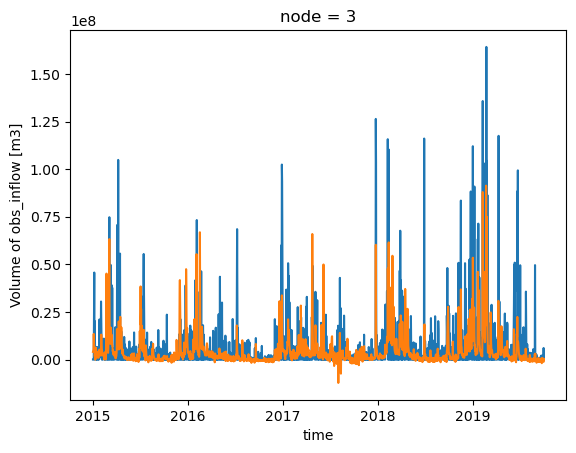

In [ ]:
noisy_obs_inflows_3[-1].plot()
forcings['obs_inflow'].sel(node=3).plot()

In [ ]:
client.close()

## add satellite data